# Unaware of IV Setup
Julian Hsu

2025-12-03

What happens when we have a classic two-stage IV setup but treat it like a single stage problem? Suppose the true DGP is:

$$Y = W \alpha + X \beta + e $$
$$W = Z \gamma + X \zeta + \epsilon $$

But we naively estimate:

$$ Y = W \alpha + X\beta + Z\gamma + e $$

Understand your data and think about your estimation approach. What happens if you have a classic instrument (or encouragement) design? These pop up all the time when we want to know the impact of something we cannot control (whether a user clicks on an ad or uses a promotional offer), but we can control how appealing that action is (the ad or promotional offer's ranking). We can randomize how appealing the action is, and use that to create experimental variation in the impact of the action we are interested in.

We should instead follow the standard two-stage setup, known as an instrumental variable (IV) model. In this setup, we strictly only allow how randomly appealing the action is to affect the outcome *indirectly through* the action.

Using simulation data (notebook here: ), I show that if we naively throw all the features into a single model, we will have a biased and under-valued estimate. This makes sense, because it allows too much flexibility and allows the randomly appearling action to *directly* impact the outcome. This would take away from the importance of the action we are interested in. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# Set seed for reproducibility
np.random.seed(4227)


## DGP and Estimating Functions

In [13]:
def datadgp(n=1000, true_effect=2.0):

    # Exogenous variables
    z = np.random.normal(0, 1, n)  # Instrument
    x = np.random.normal(0, 1, n)  # Exogenous control

    # Error term correlated with treatment
    u = np.random.normal(0, 1, n)

    # Endogenous treatment variable w
    # w is correlated with z (instrument) AND with u (error)
    w = 1.0 * z + np.random.uniform(1,2) * x + np.random.uniform(-2,-1) * u + np.random.normal(0, 0.5, n)

    # Outcome y
    # True causal effect of w on y is 2.0
    y = true_effect * w + 1.5 * x + u
    return pd.DataFrame({'y': y, 'w': w, 'x': x, 'z': z})

In [33]:
def ols_naive(data=None):
    X = sm.add_constant(data[['w', 'x', 'z']])
    model = sm.OLS(data['y'], X).fit()
    return {'coef': model.params['w'], 'se': model.bse['w'], 'pval': model.pvalues['w']}


def iv_2sls(data=None):
    X = data[['w', 'x']]
    Z = data[['z', 'x']]
    y = data['y']
    model = IV2SLS(y, X, Z).fit()
    return {'coef': model.params['w'], 'se': model.bse['w'], 'pval': model.pvalues['w']}

In [34]:
## test run of functions
data = datadgp(n=1000, true_effect=2.0)
ols_result = ols_naive(data)
iv_result = iv_2sls(data)
print("OLS Naive Result:", ols_result)
print("IV 2SLS Result:", iv_result)


OLS Naive Result: {'coef': 1.2789638191460686, 'se': 0.009449377975059781, 'pval': 0.0}
IV 2SLS Result: {'coef': 2.0127208902538176, 'se': 0.032986572442022674, 'pval': 0.0}


## Simulations

In [37]:
num_sims= 1000
true_effect_list = [1,5]
ols_result_df = pd.DataFrame()
iv_result_df = pd.DataFrame()
for t in true_effect_list:
    for s in range(num_sims):
        data = datadgp(n=1000, true_effect=t)
        ols_result = ols_naive(data)
        ols_result['true_effect'] = t
        iv_result = iv_2sls(data)
        iv_result['true_effect'] = t
        ols_result_df = pd.concat([ols_result_df, pd.DataFrame(data=ols_result, index=[s])], axis=0, ignore_index=True)
        iv_result_df = pd.concat([iv_result_df, pd.DataFrame(data=iv_result, index=[s])], axis=0, ignore_index=True)
ols_result_df['bias'] = ols_result_df['coef'] - ols_result_df['true_effect']
ols_result_df['bias_percent'] = ols_result_df['bias'] / ols_result_df['true_effect'] 
iv_result_df['bias'] = iv_result_df['coef'] - iv_result_df['true_effect']
iv_result_df['bias_percent'] = iv_result_df['bias'] / iv_result_df['true_effect']


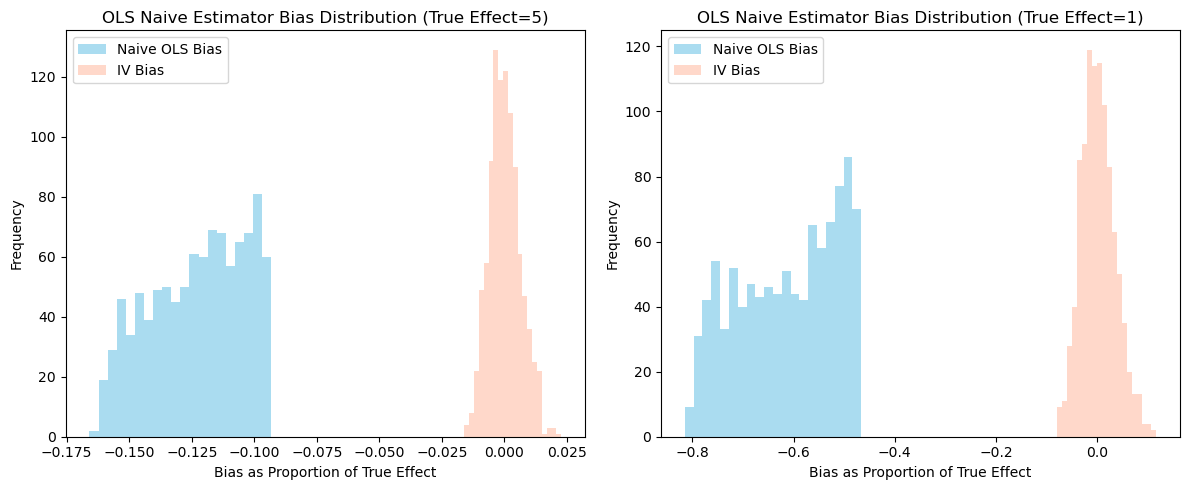

In [38]:
fig,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(ols_result_df[ols_result_df['true_effect']==5]['bias_percent'], bins=20, alpha=0.70, color='skyblue', label='Naive OLS Bias')
ax[0].hist(iv_result_df[iv_result_df['true_effect']==5]['bias_percent'], bins=20, alpha=0.30, color='coral', label='IV Bias')
ax[0].set_title("OLS Naive Estimator Bias Distribution (True Effect=5)")
ax[0].legend()
ax[0].set_xlabel("Bias as Proportion of True Effect")
ax[0].set_ylabel("Frequency")

ax[1].hist(ols_result_df[ols_result_df['true_effect']==1]['bias_percent'], bins=20, alpha=0.70, color='skyblue', label='Naive OLS Bias')
ax[1].hist(iv_result_df[iv_result_df['true_effect']==1]['bias_percent'], bins=20, alpha=0.30, color='coral', label='IV Bias')
ax[1].set_title("OLS Naive Estimator Bias Distribution (True Effect=1)")
ax[1].legend()
ax[1].set_xlabel("Bias as Proportion of True Effect")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
